Library


In [1]:
import os
import math
import time
import pickle
import numpy as np
import pandas as pd

import scipy.signal
import scipy.fftpack
from scipy.signal import resample_poly

import librosa
import soundfile as sf

import skfuzzy as fuzz
from skfuzzy import control as ctrl

import joblib

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

Path


In [2]:
PATH_MAIN = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# PATH_MAIN = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

PATH_DATASET = f"{PATH_MAIN}/Dataset"
PATH_MODEL = f"{PATH_MAIN}/Model"

Konstanta


In [3]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

Random Seed


In [4]:
RANDOM_SEED = 21

try:
    from sklearn.utils import check_random_state
    random_state = check_random_state(RANDOM_SEED)
except ImportError:
    pass

# Pra-Pemrosesan


In [5]:
def load_file_audio(path):
    audio, sr = sf.read(path)
    return np.array(audio), sr

def prapemrosesan_downmixing(audio):
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio, sr):
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    
    ratio = SAMPLE_RATE / sr
    n_samples = int(np.round(len(audio) * ratio))
    
    x_old = np.linspace(0, 1, len(audio))
    x_new = np.linspace(0, 1, n_samples)
    return np.interp(x_new, x_old, audio), SAMPLE_RATE

def prapemrosesan_padding(audio):
    if np.mod(audio.shape[0], SEGMENT_DURATION) != 0:
        padding = SEGMENT_DURATION - (audio.shape[0] % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding))
    return audio

def prapemrosesan_splitting(audio):
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = []

    for i in range(num_segments):
        start = int(i * OVERLAP_DURATION)
        end = int(start + SEGMENT_DURATION)
        segment = audio[start:end]
        if len(segment) < SEGMENT_DURATION:
            segment = np.pad(segment, (0, SEGMENT_DURATION - len(segment)), mode='constant')
        segments.append(segment)

    return np.array(segments)

# Ekstraksi Fitur


In [6]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_spectral_flatness(segment):
    return np.mean(librosa.feature.spectral_flatness(y=segment))

def get_mfcc(segment):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)

# Visualization


Satu Hasil


In [7]:
def plot_single(audio_path, list_result):
    audio, sr = load_file_audio(audio_path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    
    time_axis = np.linspace(0, len(audio) / SAMPLE_RATE, len(audio))
    
    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(os.path.basename(audio_path))
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    for i in range(0, len(list_result)):
        start_time = list_result[i][1][0]
        end_time = list_result[i][1][1]
        if list_result[i][0] == 2:
            plt.axvspan(start_time, end_time, color='blue', alpha=0)
        elif list_result[i][0] == 1:
            plt.axvspan(start_time, end_time, color='red', alpha=0.3)
        elif list_result[i][0] == 0:
            plt.axvspan(start_time, end_time, color='green', alpha=0.3)
    
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

Komparasi 2 Hasil


In [8]:
def plot_compare(path_infer, result_infer, path_label, result_label):
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    for ax, audio_path, result, title in zip(
        axs, [path_infer, path_label], [result_infer, result_label], ['Hasil Inference', 'Lebel']
    ):
        audio, sr = load_file_audio(audio_path)
        audio = prapemrosesan_downmixing(audio)
        audio, sr = prapemrosesan_resampling(audio, sr)
        
        time_axis = np.linspace(0, len(audio) / SAMPLE_RATE, len(audio))
        ax.plot(time_axis, audio, label="Amplitude", color='blue')
        ax.set_title(f"{title}: {os.path.basename(audio_path)}")
        ax.set_ylabel("Amplitude")
        
        for label, (start_time, end_time) in result:
            if label == 2:
                ax.axvspan(start_time, end_time, color='blue', alpha=0)
            elif label == 1:
                ax.axvspan(start_time, end_time, color='red', alpha=0.3)
            elif label == 0:
                ax.axvspan(start_time, end_time, color='green', alpha=0.3)
        
        ax.set_ylim(-1, 1)
        ax.legend()

    axs[1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

# Load Scaler dan Model


## Scaler


In [9]:
# Scaler Pra-Klasifikasi
p_scl = joblib.load(PATH_MODEL + "/p_scaler.pkl")

# Scaler Klasifikasi
k_scl = joblib.load(PATH_MODEL + "/k_scaler.pkl")

## Model Pra-Klasifikasi


Fuzzy Mamdani


Fungsi


In [10]:
def Antecedent(universe, name):
    return {
        'universe': universe,
        'name': name,
        'mf': {}
    }

def Consequent(universe, name):
    return {
        'universe': universe,
        'name': name,
        'mf': {}
    }

def trapmf(x, params):
    a, b, c, d = params
    y = np.zeros_like(x)
    mask1 = (a <= x) & (x < b)
    mask2 = (b <= x) & (x <= c)
    mask3 = (c < x) & (x <= d)
    y[mask1] = (x[mask1] - a) / (b - a)
    y[mask2] = 1
    y[mask3] = (d - x[mask3]) / (d - c)
    return y

def trimf(x, params):
    a, b, c = params
    y = np.zeros_like(x)
    mask1 = (a <= x) & (x < b)
    mask2 = x == b
    mask3 = (b < x) & (x <= c)
    y[mask1] = (x[mask1] - a) / (b - a)
    y[mask2] = 1
    y[mask3] = (c - x[mask3]) / (c - b)
    return y

def Rule(flatness_key, rms_key, consequent_key):
    return {
        'conditions': (flatness_key, rms_key),
        'consequent': consequent_key
    }

def ControlSystem(rules):
    return {
        'rules': rules
    }

Inisialisasi


In [11]:
rms = Antecedent(np.linspace(-1, 8, 100), 'rms')
flatness = Antecedent(np.linspace(-1, 4, 100), 'flatness')
label_var = Consequent(np.linspace(1, 2, 100), 'label')

rms['mf']['low'] = trapmf(rms['universe'], [-1, -1, -0.67, -0.565])
rms['mf']['medium'] = trimf(rms['universe'], [-0.67, -0.565, -0.46])
rms['mf']['high'] = trapmf(rms['universe'], [-0.565, -0.46, 8, 8])

flatness['mf']['rigid'] = trapmf(flatness['universe'], [-1, -1, -0.45, -0.35])
flatness['mf']['smooth'] = trapmf(flatness['universe'], [-0.45, -0.35, 4, 4])

label_var['mf']['event'] = trimf(label_var['universe'], [1, 1, 1])
label_var['mf']['nonevent'] = trimf(label_var['universe'], [2, 2, 2])

rule1 = Rule('smooth', 'low', 'nonevent')
rule2 = Rule('smooth', 'medium', 'nonevent')
rule3 = Rule('smooth', 'high', 'event')
rule4 = Rule('rigid', 'low', 'nonevent')
rule5 = Rule('rigid', 'medium', 'nonevent')
rule6 = Rule('rigid', 'high', 'event')

mamdani_ctrl = ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

In [12]:
def fuzzy_inference(rms_value, flatness_value):
    rms_degrees = {k: np.interp(rms_value, rms['universe'], v) for k, v in rms['mf'].items()}
    flatness_degrees = {k: np.interp(flatness_value, flatness['universe'], v) for k, v in flatness['mf'].items()}
    label_universe = label_var['universe']
    aggregated_output = np.zeros_like(label_universe)

    for rule in mamdani_ctrl['rules']:
        flatness_key, rms_key = rule['conditions']
        consequent_key = rule['consequent']
        degree = min(flatness_degrees[flatness_key], rms_degrees[rms_key])
        aggregated_output = np.maximum(aggregated_output, np.minimum(degree, label_var['mf'][consequent_key]))

    return 1.5 if np.sum(aggregated_output) == 0 else np.sum(label_universe * aggregated_output) / np.sum(aggregated_output)

def p_mamdani(X):
    return int(round(fuzzy_inference(*X[0])))

Supervised


In [13]:
# Logistic Regression
p_lr = joblib.load(PATH_MODEL + "/p_lr.pkl")

# Descision Tree
p_dt = joblib.load(PATH_MODEL + "/p_dt.pkl")

# LGBM Classifier
p_lgbm = joblib.load(PATH_MODEL + "/p_lgbm.pkl")

## Model Klasifikasi


Supervised


In [14]:
# LGBM
k_lgbm = joblib.load(PATH_MODEL + "/k_lgbm.pkl")

# CNN
k_mlp = joblib.load(PATH_MODEL + "/k_mlp.pkl")

# Main


## Single Audio Inference


In [15]:
def single_inference(path, praklasifikasi, klasifikasi):
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)
    
    list_result = []
    time = 0
    for segment in segments:
        timestamp = [time * 0.5, (time*0.5) + 1]
        time += 1
        
        rms = get_rms(segment)
        flatness = get_spectral_flatness(segment)
        rms_scaled, flatness_scaled = p_scl.transform([[rms, flatness]])[0]
        
        if praklasifikasi == "mamdani":
            label = p_mamdani([[rms_scaled, flatness_scaled]])
        elif praklasifikasi == "lr":
            label = p_lr.predict([[rms_scaled, flatness_scaled]])[0]
        elif praklasifikasi == "dt":
            label = p_dt.predict([[rms_scaled, flatness_scaled]])[0]
        elif praklasifikasi == "lgbm":
            label = p_lgbm.predict([[rms_scaled, flatness_scaled]])[0]

        if label != 2:
            mfcc = get_mfcc(segment)
            mfcc = np.array(mfcc)
            mfcc = mfcc.reshape(1, -1)
            mfcc_scaled = k_scl.transform(mfcc)
            
            if klasifikasi == "lgbm":
                label = k_lgbm.predict(mfcc_scaled)[0]
            elif klasifikasi == "mlp":
                label = k_mlp.predict(mfcc_scaled)[0]
        
        list_result.append([label, timestamp])
    
    return list_result

Running


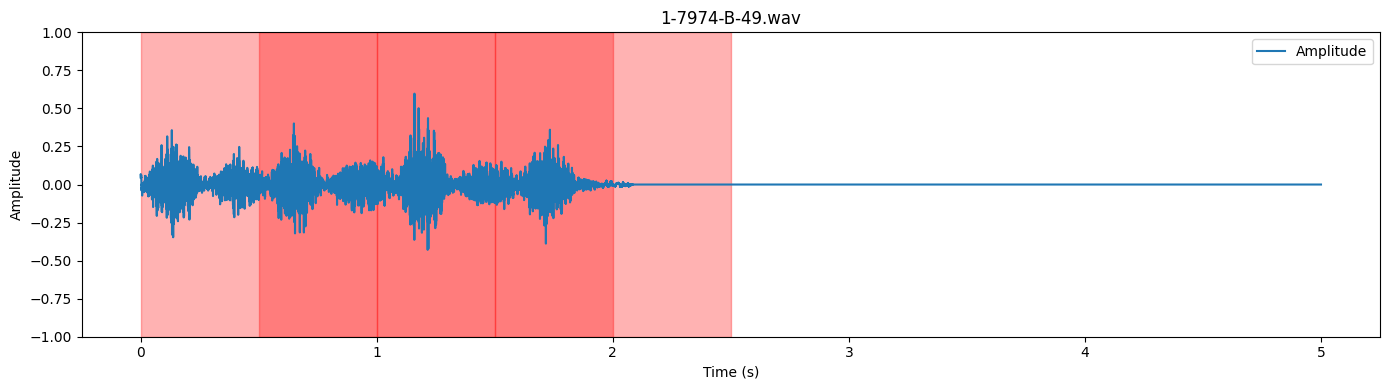

In [16]:
audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data\1-7974-B-49.wav"
# audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto\498380.mp3"

hasil_inferensi = single_inference(audio_path, "mamdani", "lgbm")
plot_single(audio_path, hasil_inferensi)

In [17]:
# audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data"
# audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto"

# for file in os.listdir(audio_path):
#     hasil_inferensi = single_inference(f"{audio_path}/{file}")
#     plot_single(f"{audio_path}/{file}", hasil_inferensi)

# Analisa


Load Dataset Anotasi


In [18]:
with open(f"{PATH_DATASET}/dataset_raw_conc.pkl", "rb") as f:
    dataset_raw_conc = pickle.load(f)

Running


In [27]:
dataset_raw_conc_adj = []

for data_raw in dataset_raw_conc:
    label_timestamp = []
    for i in range(0, len(data_raw['label'])):
        label_timestamp.append([data_raw['label'][i], data_raw['timestamp'][i]])
    dataset_raw_conc_adj.append({
        'name': data_raw['name'],
        'path': data_raw['path'],
        'label_timestamp': label_timestamp
    })

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


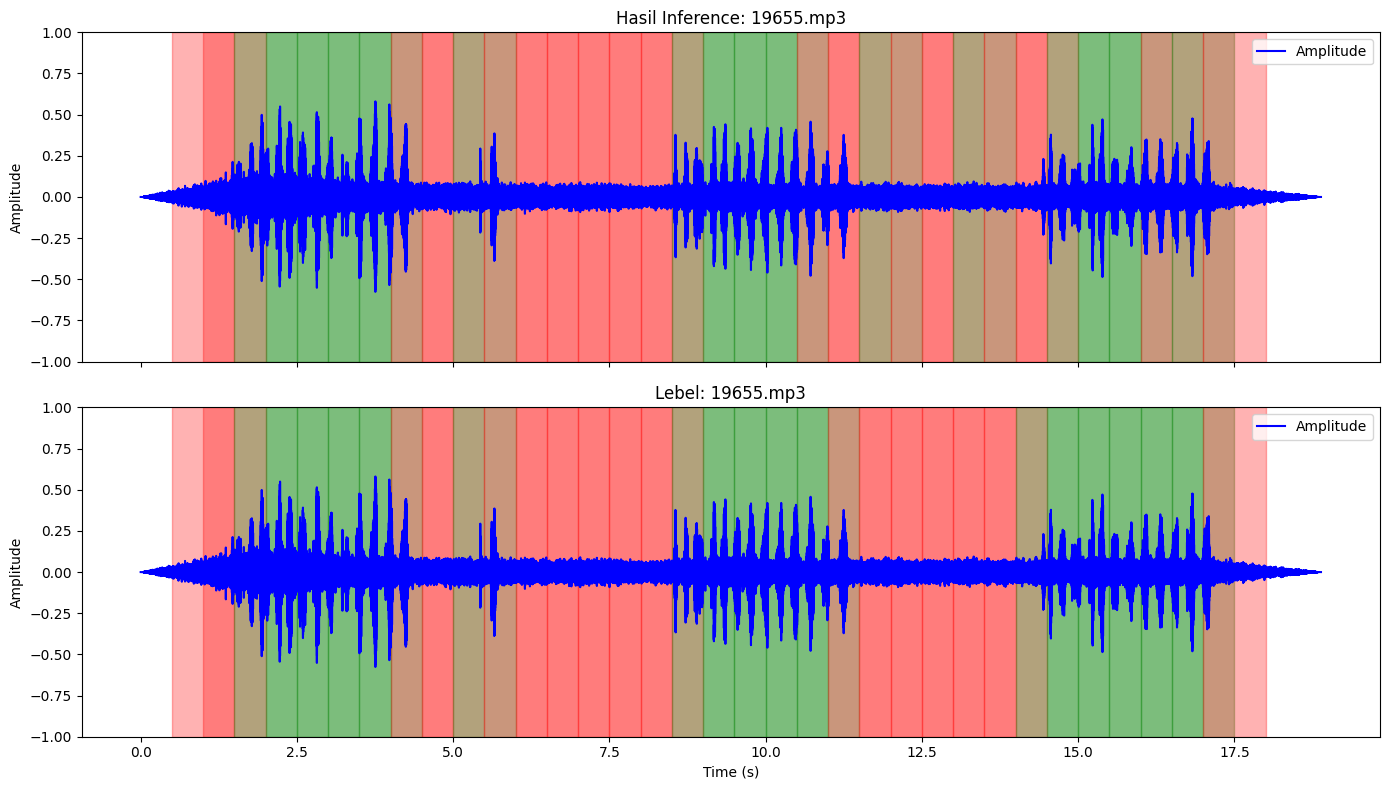

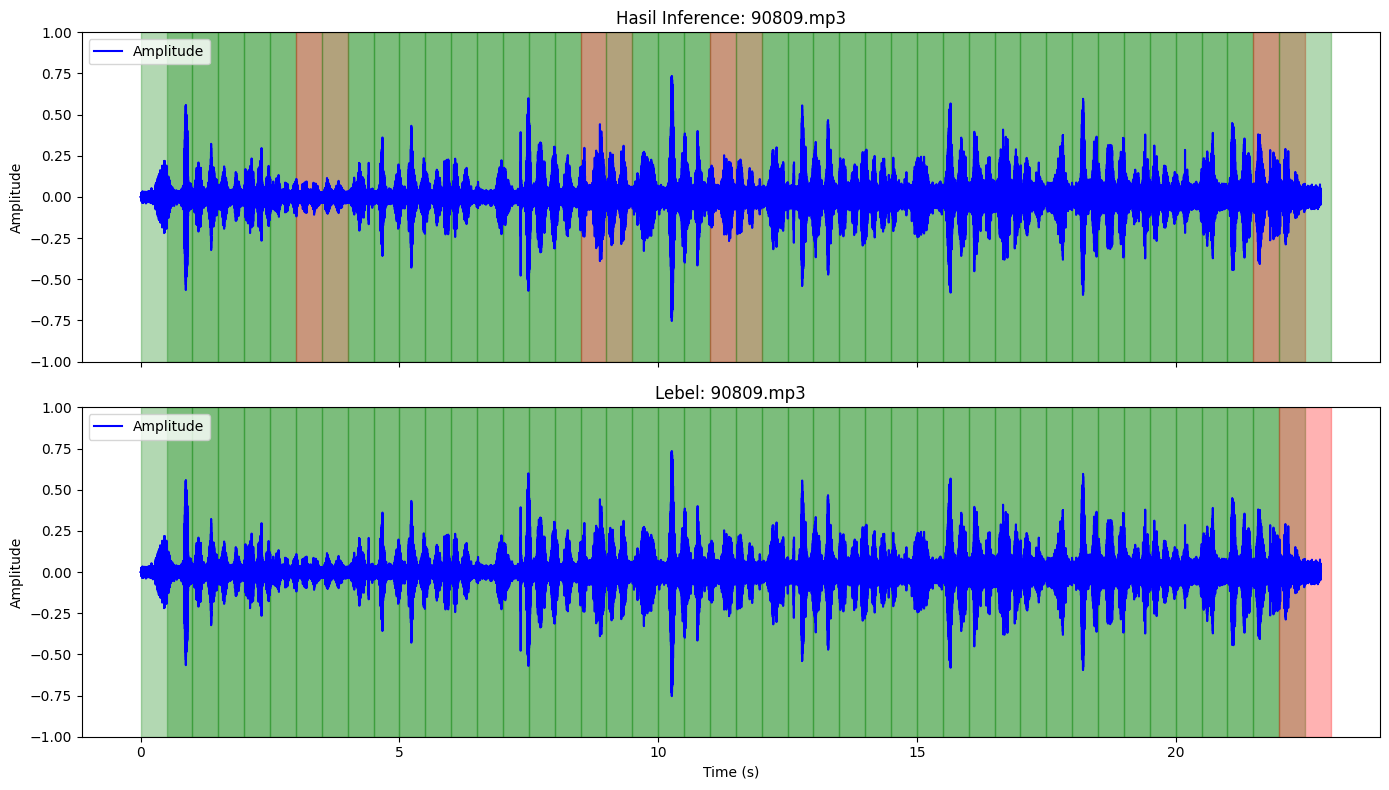

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


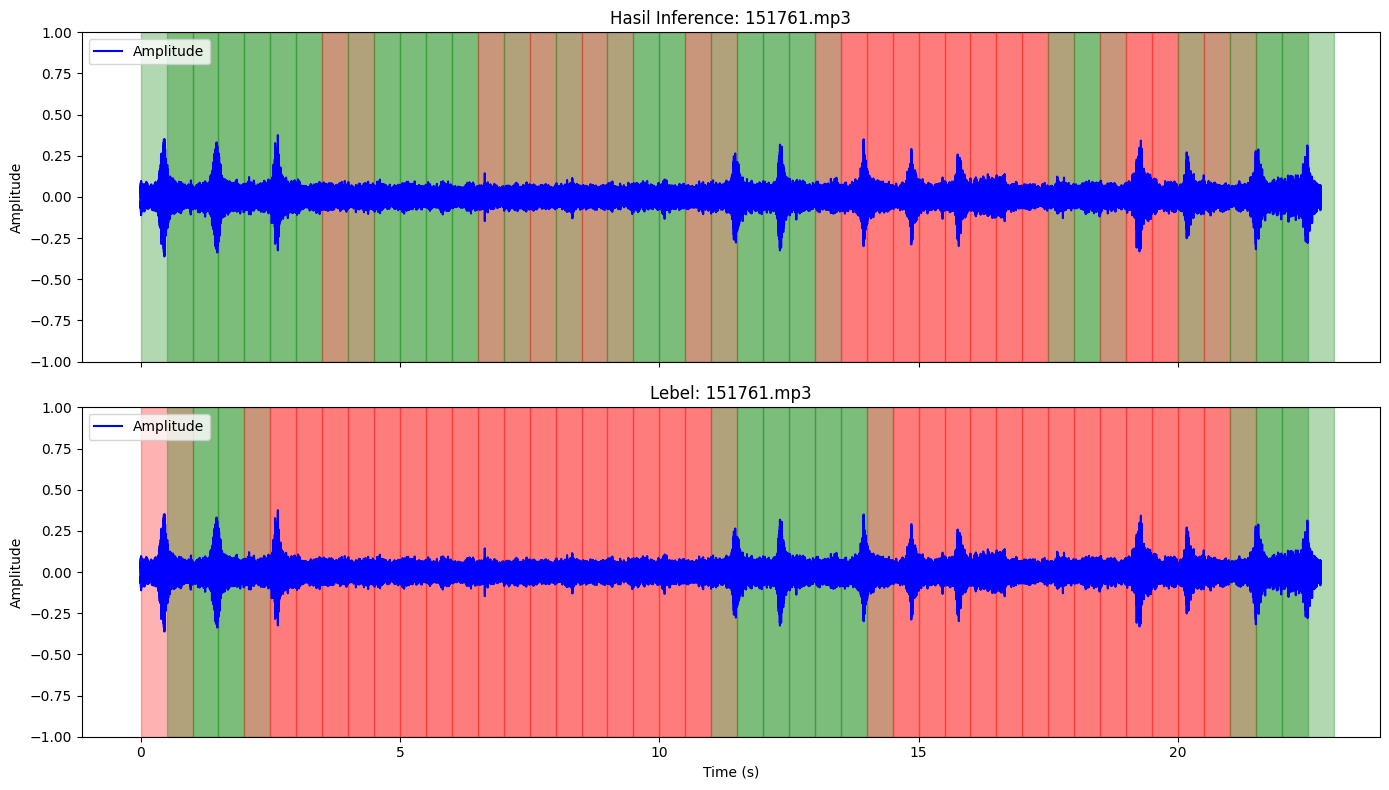

KeyboardInterrupt: 

In [28]:
list_result = []

for data_raw in dataset_raw_conc_adj:
    hasil_inferensi = single_inference(data_raw["path"], "mamdani", "lgbm")
    path_infer = data_raw["path"]
    result_infer = hasil_inferensi
    path_label = data_raw["path"]
    result_label = data_raw["label_timestamp"]
    
    list_result.append({
        "path": path_infer,
        "pred": result_infer,
        "label": result_label
    })
    
    plot_compare(path_infer, result_infer, path_label, result_label)

In [ ]:
# y_all = []

# for result in list_result:
#     y_pred = []
#     for i in range(0, len(result)):
#         pred = result["pred"]
#         label = result["label"]
#         for j in range(0, len(pred)):
#             if label[j][1] == pred[j][1]:
#                 y_all.append({
#                     "path": result["path"],
#                     "pred": pred[j][0],
#                     "label": label[j][0]
#                 })

In [ ]:
# y_pred_all = [y["pred"] for y in y_all]
# y_label_all = [y["label"] for y in y_all]

In [ ]:
# print(f"Accuracy: {accuracy_score(y_label_all, y_pred_all)}")
# print(f"Recall: {recall_score(y_label_all, y_pred_all, average='macro')}")
# print(f"Precision: {precision_score(y_label_all, y_pred_all, average='macro')}")
# print(f"F1-score: {f1_score(y_label_all, y_pred_all, average='macro')}")
# print(f"Confusion Matrix:\n {confusion_matrix(y_label_all, y_pred_all)}")

# Run All Model


In [24]:
list_praklasifikasi = ["mamdani", "lr", "dt", "lgbm"]
list_klasifikasi = ["mlp", "lgbm"]
list_model = [[x, y] for x in list_praklasifikasi for y in list_klasifikasi]

skor_hasil = []

for praklasifikasi, klasifikasi in list_model:
    list_result = []

    for data_raw in dataset_raw_conc_adj:
        runtime_start = time.time()
        hasil_inferensi = single_inference(data_raw["path"], praklasifikasi, klasifikasi)
        runtime_end = time.time()
        runtime = runtime_end - runtime_start 
        path_infer = data_raw["path"]
        result_infer = hasil_inferensi
        path_label = data_raw["path"]
        result_label = data_raw["label_timestamp"]
        
        list_result.append({
            "path": path_infer,
            "pred": result_infer,
            "label": result_label,
            "runtime": runtime
        })
        
    y_all = []

    for result in list_result:
        y_pred = []
        for i in range(0, len(result)):
            pred = result["pred"]
            label = result["label"]
            for j in range(0, len(pred)):
                if label[j][1] == pred[j][1]:
                    y_all.append({
                        "path": result["path"],
                        "pred": pred[j][0],
                        "label": label[j][0]
                    })
    y_pred_all = [y["pred"] for y in y_all]
    y_label_all = [y["label"] for y in y_all]

    print(f"\nModel Praklasifikasi: {praklasifikasi}, Model Klasifikasi: {klasifikasi}")
    print(f"Accuracy: {accuracy_score(y_label_all, y_pred_all)}")
    print(f"Recall: {recall_score(y_label_all, y_pred_all, average='macro')}")
    print(f"Precision: {precision_score(y_label_all, y_pred_all, average='macro')}")
    print(f"F1-score: {f1_score(y_label_all, y_pred_all, average='macro')}")
    print(f"Confusion Matrix:\n {confusion_matrix(y_label_all, y_pred_all)}")
    print(f"Average Runtime: {np.mean([x['runtime'] for x in list_result])}")
    print(f"Median Runtime: {np.median([x['runtime'] for x in list_result])}")
    
    skor_hasil.append({
        "klasifikasi": klasifikasi,
        "praklasifikasi": praklasifikasi,
        "accuracy": accuracy_score(y_label_all, y_pred_all),
        "recall": recall_score(y_label_all, y_pred_all, average='macro'),
        "precision": precision_score(y_label_all, y_pred_all, average='macro'),
        "f1_score": f1_score(y_label_all, y_pred_all, average='macro'),
        "confusion_matrix": confusion_matrix(y_label_all, y_pred_all),
        "average_runtime": np.mean([x['runtime'] for x in list_result]),
        "median_runtime": np.median([x['runtime'] for x in list_result])
    })


Model Praklasifikasi: mamdani, Model Klasifikasi: mlp
Accuracy: 0.806577480490524
Recall: 0.813185301117604
Precision: 0.8098460247140107
F1-score: 0.8089371816369816
Confusion Matrix:
 [[2092   72  444]
 [ 636 2032    0]
 [  48  188 1664]]
Average Runtime: 0.5638533532619476
Median Runtime: 0.2692739963531494

Model Praklasifikasi: mamdani, Model Klasifikasi: lgbm
Accuracy: 0.8344481605351171
Recall: 0.8379428609879755
Precision: 0.8317233073158437
F1-score: 0.8334715670587792
Confusion Matrix:
 [[2012  152  444]
 [ 356 2312    0]
 [   4  232 1664]]
Average Runtime: 0.6374644011259079
Median Runtime: 0.2833765745162964

Model Praklasifikasi: lr, Model Klasifikasi: mlp
Accuracy: 0.7987736900780379
Recall: 0.800312628638861
Precision: 0.8017073994914107
F1-score: 0.7997230696183516
Confusion Matrix:
 [[2156   72  380]
 [ 636 2032    0]
 [  60  296 1544]]
Average Runtime: 0.5516850739717484
Median Runtime: 0.2619267702102661

Model Praklasifikasi: lr, Model Klasifikasi: lgbm
Accuracy: 0

In [25]:
df_result = pd.DataFrame(skor_hasil, columns=["praklasifikasi", "klasifikasi", "accuracy", "recall", "precision", "f1_score", "average_runtime", "median_runtime"])

In [26]:
df_result.sort_values("accuracy", ascending=True)

,praklasifikasi,klasifikasi,accuracy,recall,precision,f1_score,average_runtime,median_runtime
2,lr,mlp,0.798774,0.800313,0.801707,0.799723,0.551685,0.261927
0,mamdani,mlp,0.806577,0.813185,0.809846,0.808937,0.563853,0.269274
4,dt,mlp,0.813266,0.829677,0.821860,0.815155,0.522579,0.239150
6,lgbm,mlp,0.821070,0.824867,0.824208,0.822194,0.644180,0.278785
3,lr,lgbm,0.825530,0.824048,0.824075,0.823554,0.610409,0.265026
1,mamdani,lgbm,0.834448,0.837943,0.831723,0.833472,0.637464,0.283377
5,dt,lgbm,0.835563,0.849506,0.838615,0.835084,0.588985,0.285101
7,lgbm,lgbm,0.838907,0.840606,0.837583,0.838920,0.642034,0.272753


In [29]:
df_result.to_excel("Result_Kombinasi_Model.xlsx", index=False)

with open(f"{PATH_MAIN}/Result_Kombinasi_Model.pkl", "wb") as f:
    pickle.dump(skor_hasil, f)